# TABLE OF CONTENTS
* [**1. INTRODUCTION**](#1-INTRODUCTION)
    * [1.1 Import Libraries](#1.1-Import-Libraries)
    * [1.2 Download data](#1.2-Download-data)
    * [1.3 Data description](#1.3-Data-description)
* [**2. DATA VISUALIZATION**](#2-DATA-VISUALIZATION)
    * [2.1 Close Price](#2.1-Close-Price)
    * [2.2 Moving Average](#2.2-Moving-Average)
    * [2.3 Daily Return](#2.3-Daily-Return)
    * [2.4 Volume](#2.4-Volume)
* [**3. BOEING PRICE PREDICTION**](#3-BOEING-PRICE-PREDICTION)
    * [3.1 Inspect and Cleanup](#3.1-Inspect-and-Cleanup)
    * [3.2 Feature engineering](#3.2-Feature-engineering)
    * [3.3 Data Windowing](#3.3-Data-Windowing) 
    * [3.4 Split Window](#3.4-Split-Window)
    * [3.5 Plot](#3.5-Plot)
    * [3.6 Create Dataset](#3.6-Create-Dataset)
    * [3.7 Build & Train model](#3.7-Build-&-Train-model)
        * [3.7.1 Simple CNN](#3.7.1-Simple-CNN)
        * [3.7.2 Multi LSTM](#3.7.2-Multi-LSTM)
        * [3.7.3 Complex CNN](#3.7.3-Complex-CNN)
        * [3.7.4 CNN + LSTM](#3.7.4-CNN-+-LSTM)
        * [3.7.5 LSTM + Dense](#3.7.5-LSTM-+-Dense)
* [**4. RESULT**](#4-RESULT) 
* [**5. CONCLUSION**](#5-CONCLUSION)


# 1 INTRODUCTION

I suppose you may have thought about utilizing ML/AI to forecast stock price at some point. That was, in fact, my fantasy when I was a freshman in college. I set out to create a model to forecast them back then and wanted to live a prosperous life for the rest of my days. But I ran into trouble.

* I didn't anything about finance
* In lack of knowledge about ML/AI
* My computer wasn't powerful (It's pretty weak to run even the simple code on VScode)

Even though I have found solutions to all of the aforementioned issues, I am currently unable to pay my rent :)).  Just try, even if we can't make a dream come true.

## Problems
I started to read papers and searching for the code on Kaggle. And I found this Note book: [📊Stock Market Analysis 📈 + Prediction using LSTM](https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm/notebook). In general, the visualization was really good. Nevertheless, the APPLE stock prediction was wrong (The model is simply predict by mimicking the price of the day before). And I found that a lot of people make the same mistakes. 

1. Using the close price only (this feature has a normal distribution which is almost random)
2. Using Minmax scaler instead of Standard scaler (the close price doesn't have upper bound)
3. Not compare their model to a baseline model (Naive forecast)
4. Not using other features to predict (News, volume, oil price, FED interest rate)
5. The model is so simple (I guess its because they want to make a reference)
6. Final test on the valid data???

You can see more with [LSTM time series + stock price prediction = FAIL](https://www.kaggle.com/code/carlmcbrideellis/lstm-time-series-stock-price-prediction-fail) and [Predicting Stock Prices with LSTMs: One Mistake Everyone Makes](https://www.youtube.com/watch?v=Vfx1L2jh2Ng&list=WL&index=4)

However, instead of predicting price, some papers are trying to solve the classification task (Buy, Sell, Keep) with the given information to optimize the value. Or they tried to applied other models to solve this task (CNN, CNN+LSTM, GAN...)

## Scope

It goes without saying that there are several issues to address and  methods to tackle this task in a single notebook. I think a whole system is required. I'll attempt to address a few minor problems in this notebook, which you are welcome to use as a reference. Along the way, we'll be tackling the following issues:

* Using Standard scaler
* Using other features like oil price/ other stock price/ return price/Volume to predict
* More complicated model (I'll teach you how to create a model function, not using Sequential)
* How to split data and test it right
* Compare our model to Naive basline model

Even though I really want to develop a system that uses news and company reports (P/E, P/B, and Capital) as features or converts them into a classification algorithm, I don't have any data, and the system would be too large to fit in a single notebook.

The models I used in this notebook are
* [Simple CNN](#3.7.1-Simple-CNN)
* [Multi LSTM](#3.7.2-Multi-LSTM)
* [Complex CNN](#3.7.3-Complex-CNN)
* [CNN + LSTM](#3.7.4-CNN-+-LSTM)
* [LSTM + Dense](#3.7.5-LSTM-+-Dense)

In [1]:
# !pip install -q hvplot
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader
!pip install -q yfinance

## 1.1 Import Libraries

In [2]:
import pandas as pd
import numpy as np

import IPython
import IPython.display

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
import tensorflow as tf
from keras.layers import Dense, LSTM

# For time stamps
from datetime import datetime

## 1.2 Download data

I'll make a Boeing stock forecast here. Oil price and financial indexes like those are some aspects I'd like to employ (S&P 500 or Dow Jones). Sadly, I'm not sure how to crawl these prices with yfinance, so I'll replace them with the prices of Shell and JPMorgan shares. You can see they're quite similar in the Data visualization part. I suppose it works.

In [3]:
# Set up End and Start times for data grab
tech_list = ['BA','SHEL','JPM']

end = datetime.now()
start = datetime(end.year - 15, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
company_list = [BA ,SHEL, JPM]
company_name = ["BOEING", "SHELL", "JPMORGAN"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
print (df.tail(10))

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-07-25  115.839996  116.459999  114.769997  115.220001  115.220001   
2022-07-26  114.580002  115.580002  113.029999  113.419998  113.419998   
2022-07-27  114.010002  115.739998  113.300003  115.239998  115.239998   
2022-07-28  115.250000  115.980003  113.529999  114.809998  114.809998   
2022-07-29  115.589996  116.500000  114.790001  115.360001  115.360001   
2022-08-01  114.500000  115.110001  113.070000  114.209999  114.209999   
2022-08-02  113.919998  114.400002  112.269997  112.430000  112.430000   
2022-08-03  113.449997  114.099998  111.709999  113.610001  113.610001   
2022-08-04  112.849998  113.320000  111.019997  112.360001  112.360001   
2022-08-05  112.529999  116.190002  112.050003  115.760002  115.760002   

              Volume company_name  
Date                               
2022-07-25   9394000     JPMORGAN  
202

## 1.3 Data description

In [5]:
# Summary Stats
BA.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3777.000000,3777.000000,3777.000000,3777.000000,3777.000000,3.777000e+03
mean,154.388152,156.189293,152.478594,154.326955,142.975906,7.384575e+06
std,98.731799,99.843749,97.569723,98.711669,101.301514,8.382790e+06
min,29.219999,30.020000,29.049999,29.360001,22.244295,7.889000e+05
25%,73.419998,74.120003,72.839996,73.529999,59.255318,3.551800e+06
50%,130.399994,131.600006,128.830002,130.279999,115.633873,4.950400e+06
75%,206.059998,208.940002,203.339996,206.440002,205.059998,7.770700e+06
max,446.010010,446.010010,440.190002,440.619995,430.299957,1.032128e+08


In [6]:
# General info
BA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3777 entries, 2007-08-07 to 2022-08-05
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3777 non-null   float64
 1   High          3777 non-null   float64
 2   Low           3777 non-null   float64
 3   Close         3777 non-null   float64
 4   Adj Close     3777 non-null   float64
 5   Volume        3777 non-null   int64  
 6   company_name  3777 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 236.1+ KB


In [7]:
#stock = yf.Ticker("BA")
#stock.info

In [8]:
BA.head()

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2007-08-07,103.699997,104.120003,102.300003,103.220001,75.120750,5250000,BOEING
2007-08-08,103.099998,104.190002,100.709999,102.720001,75.011200,5820700,BOEING
2007-08-09,100.790001,102.230003,98.019997,98.300003,71.783524,8723900,BOEING
2007-08-10,96.949997,98.510002,94.000000,98.440002,71.885750,11406200,BOEING
2007-08-13,99.459999,100.910004,99.250000,100.050003,73.061440,6144600,BOEING


# 2 DATA VISUALIZATION

## 2.1 Close Price
Let's see how oil price (SHELL) and market (JPMORGAN) correlate to Boeing stock

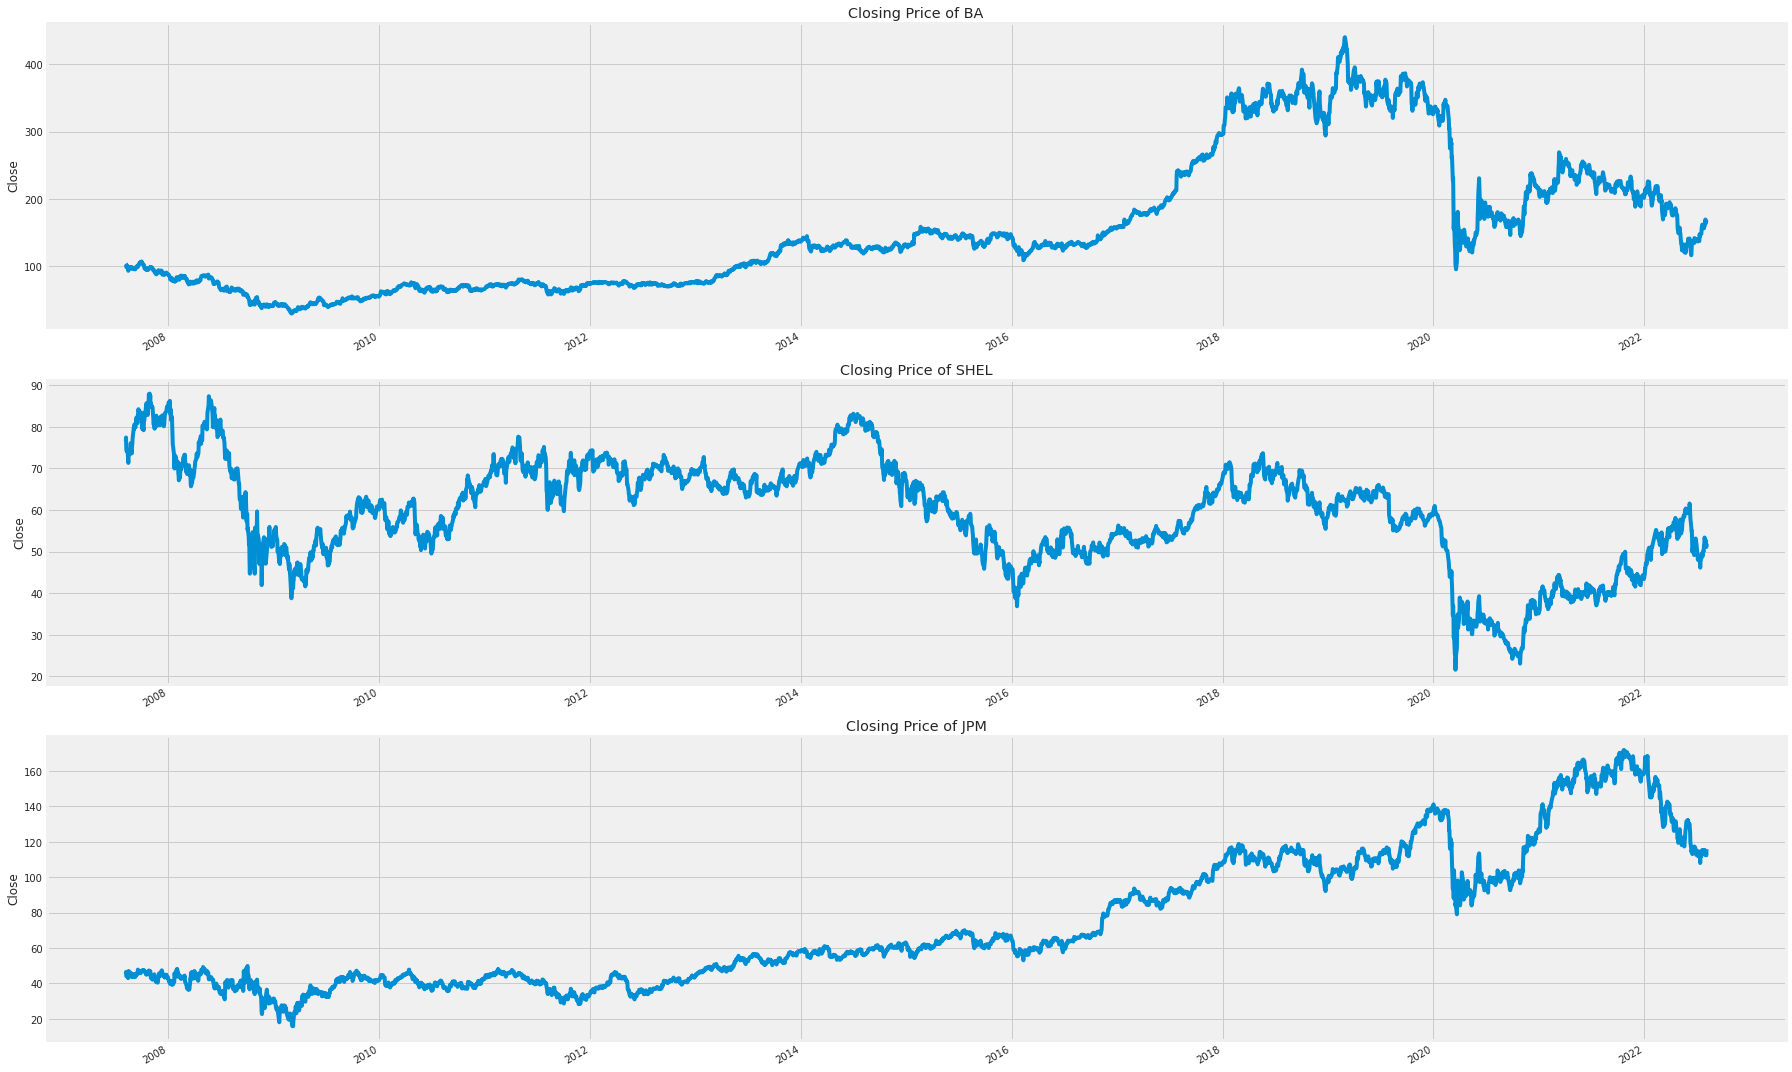

In [9]:
# Let's see a historical view of the closing price

plt.figure(figsize=(25, 15))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(3, 1, i)
    company['Close'].plot()
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

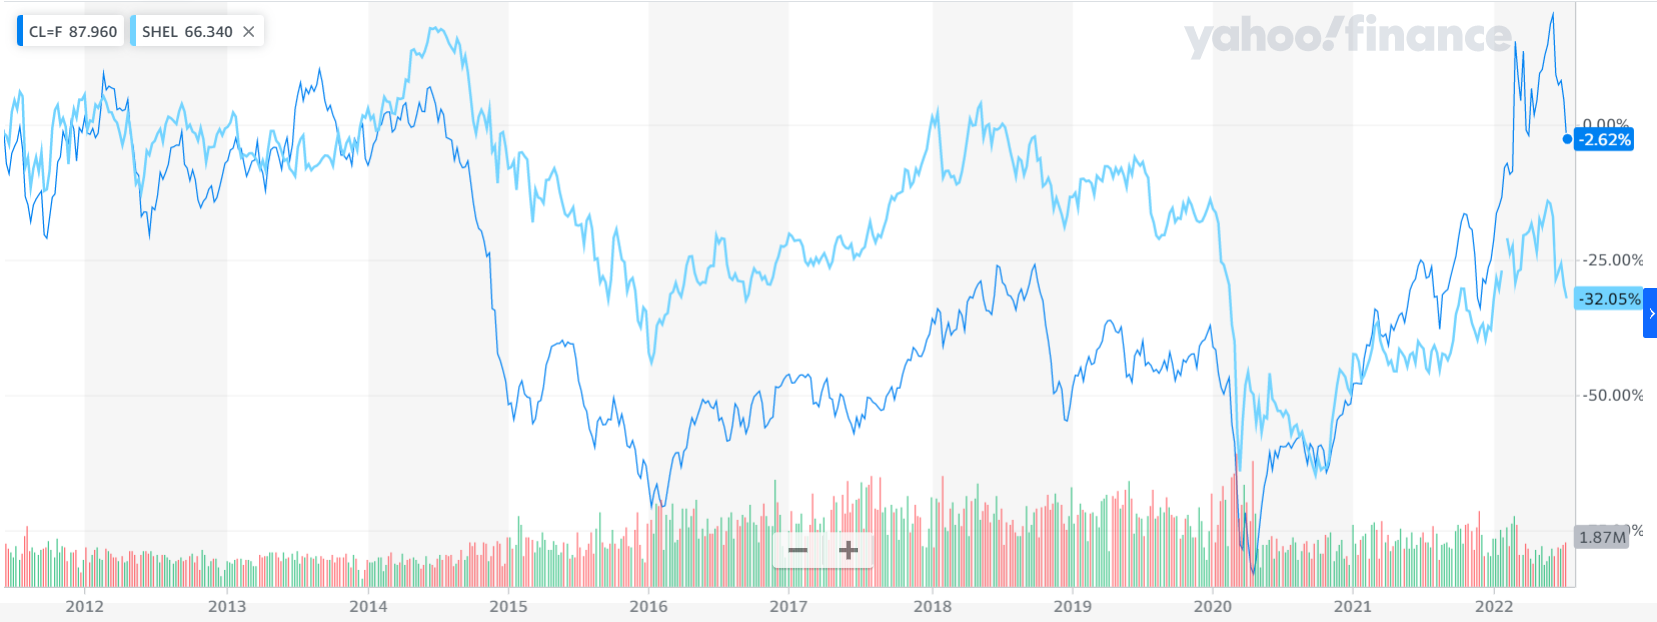

**SHEL and Crude Oil price comparison**

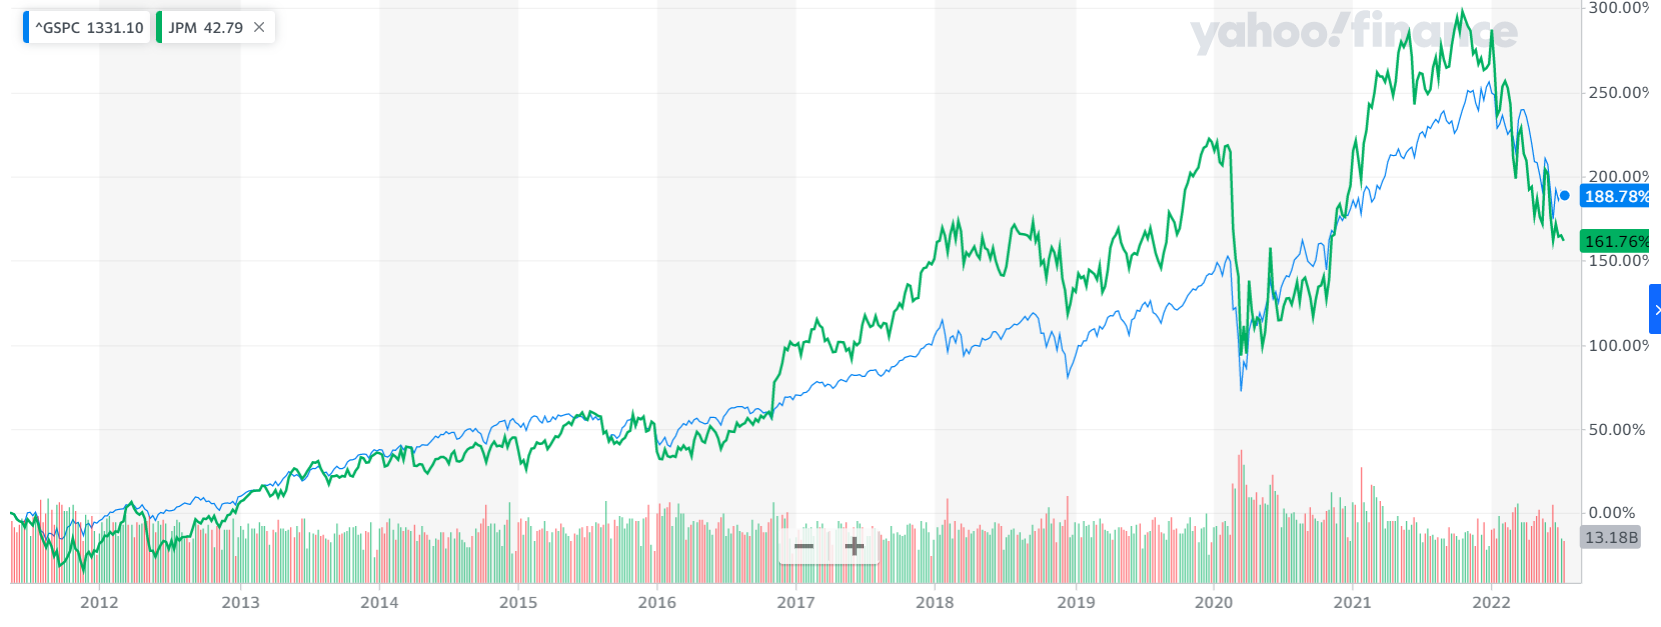

**S&P500 and JPMORGAN price comparison**

## 2.2 Moving Average

The MA12 and MA26 are used to calculate [MACD](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/macd#:~:text=Description,lines%20which%20oscillate%20without%20boundaries.)

In [10]:
ma_day = [12, 26, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA{ma}"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


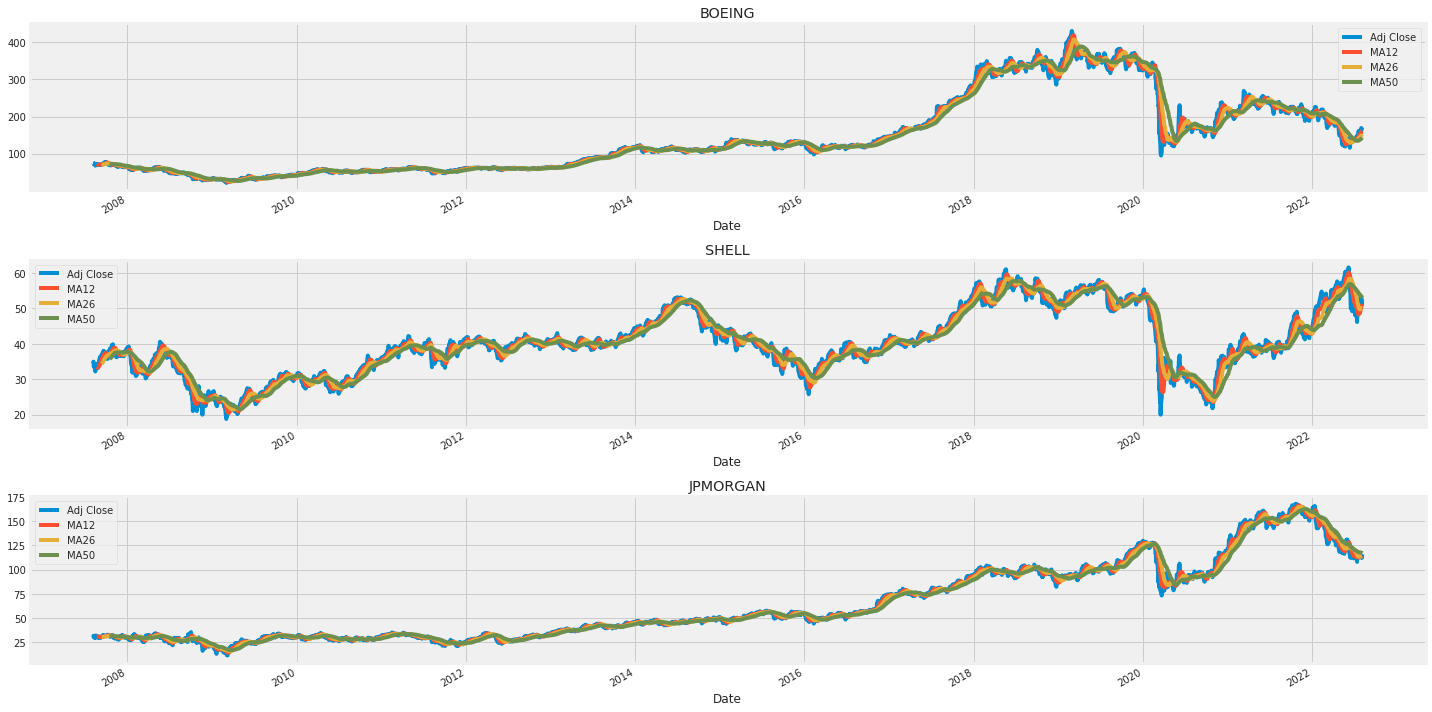

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(20)


BA[['Adj Close', 'MA12', 'MA26', 'MA50']].plot(ax=axes[0])
axes[0].set_title('BOEING')

SHEL[['Adj Close', 'MA12', 'MA26', 'MA50']].plot(ax=axes[1])
axes[1].set_title('SHELL')

JPM[['Adj Close', 'MA12', 'MA26', 'MA50']].plot(ax=axes[2])
axes[2].set_title('JPMORGAN')

fig.tight_layout()

Look at the picture above. I won't discuss much about the market before to 2018, as I don't have much knowledge in that area. But we may observe some things here.

1. Between 2020 and 2021, the impact of Covid19 is clearly seen. The three stocks all fell considerably.
2. The businesses began to expand by the end of 2021.
3. As a result of the conflict between Ukraine and Russia, the price of oil shot up, while JPMorgan and Boeing stock fell.

## 2.3 Daily Return

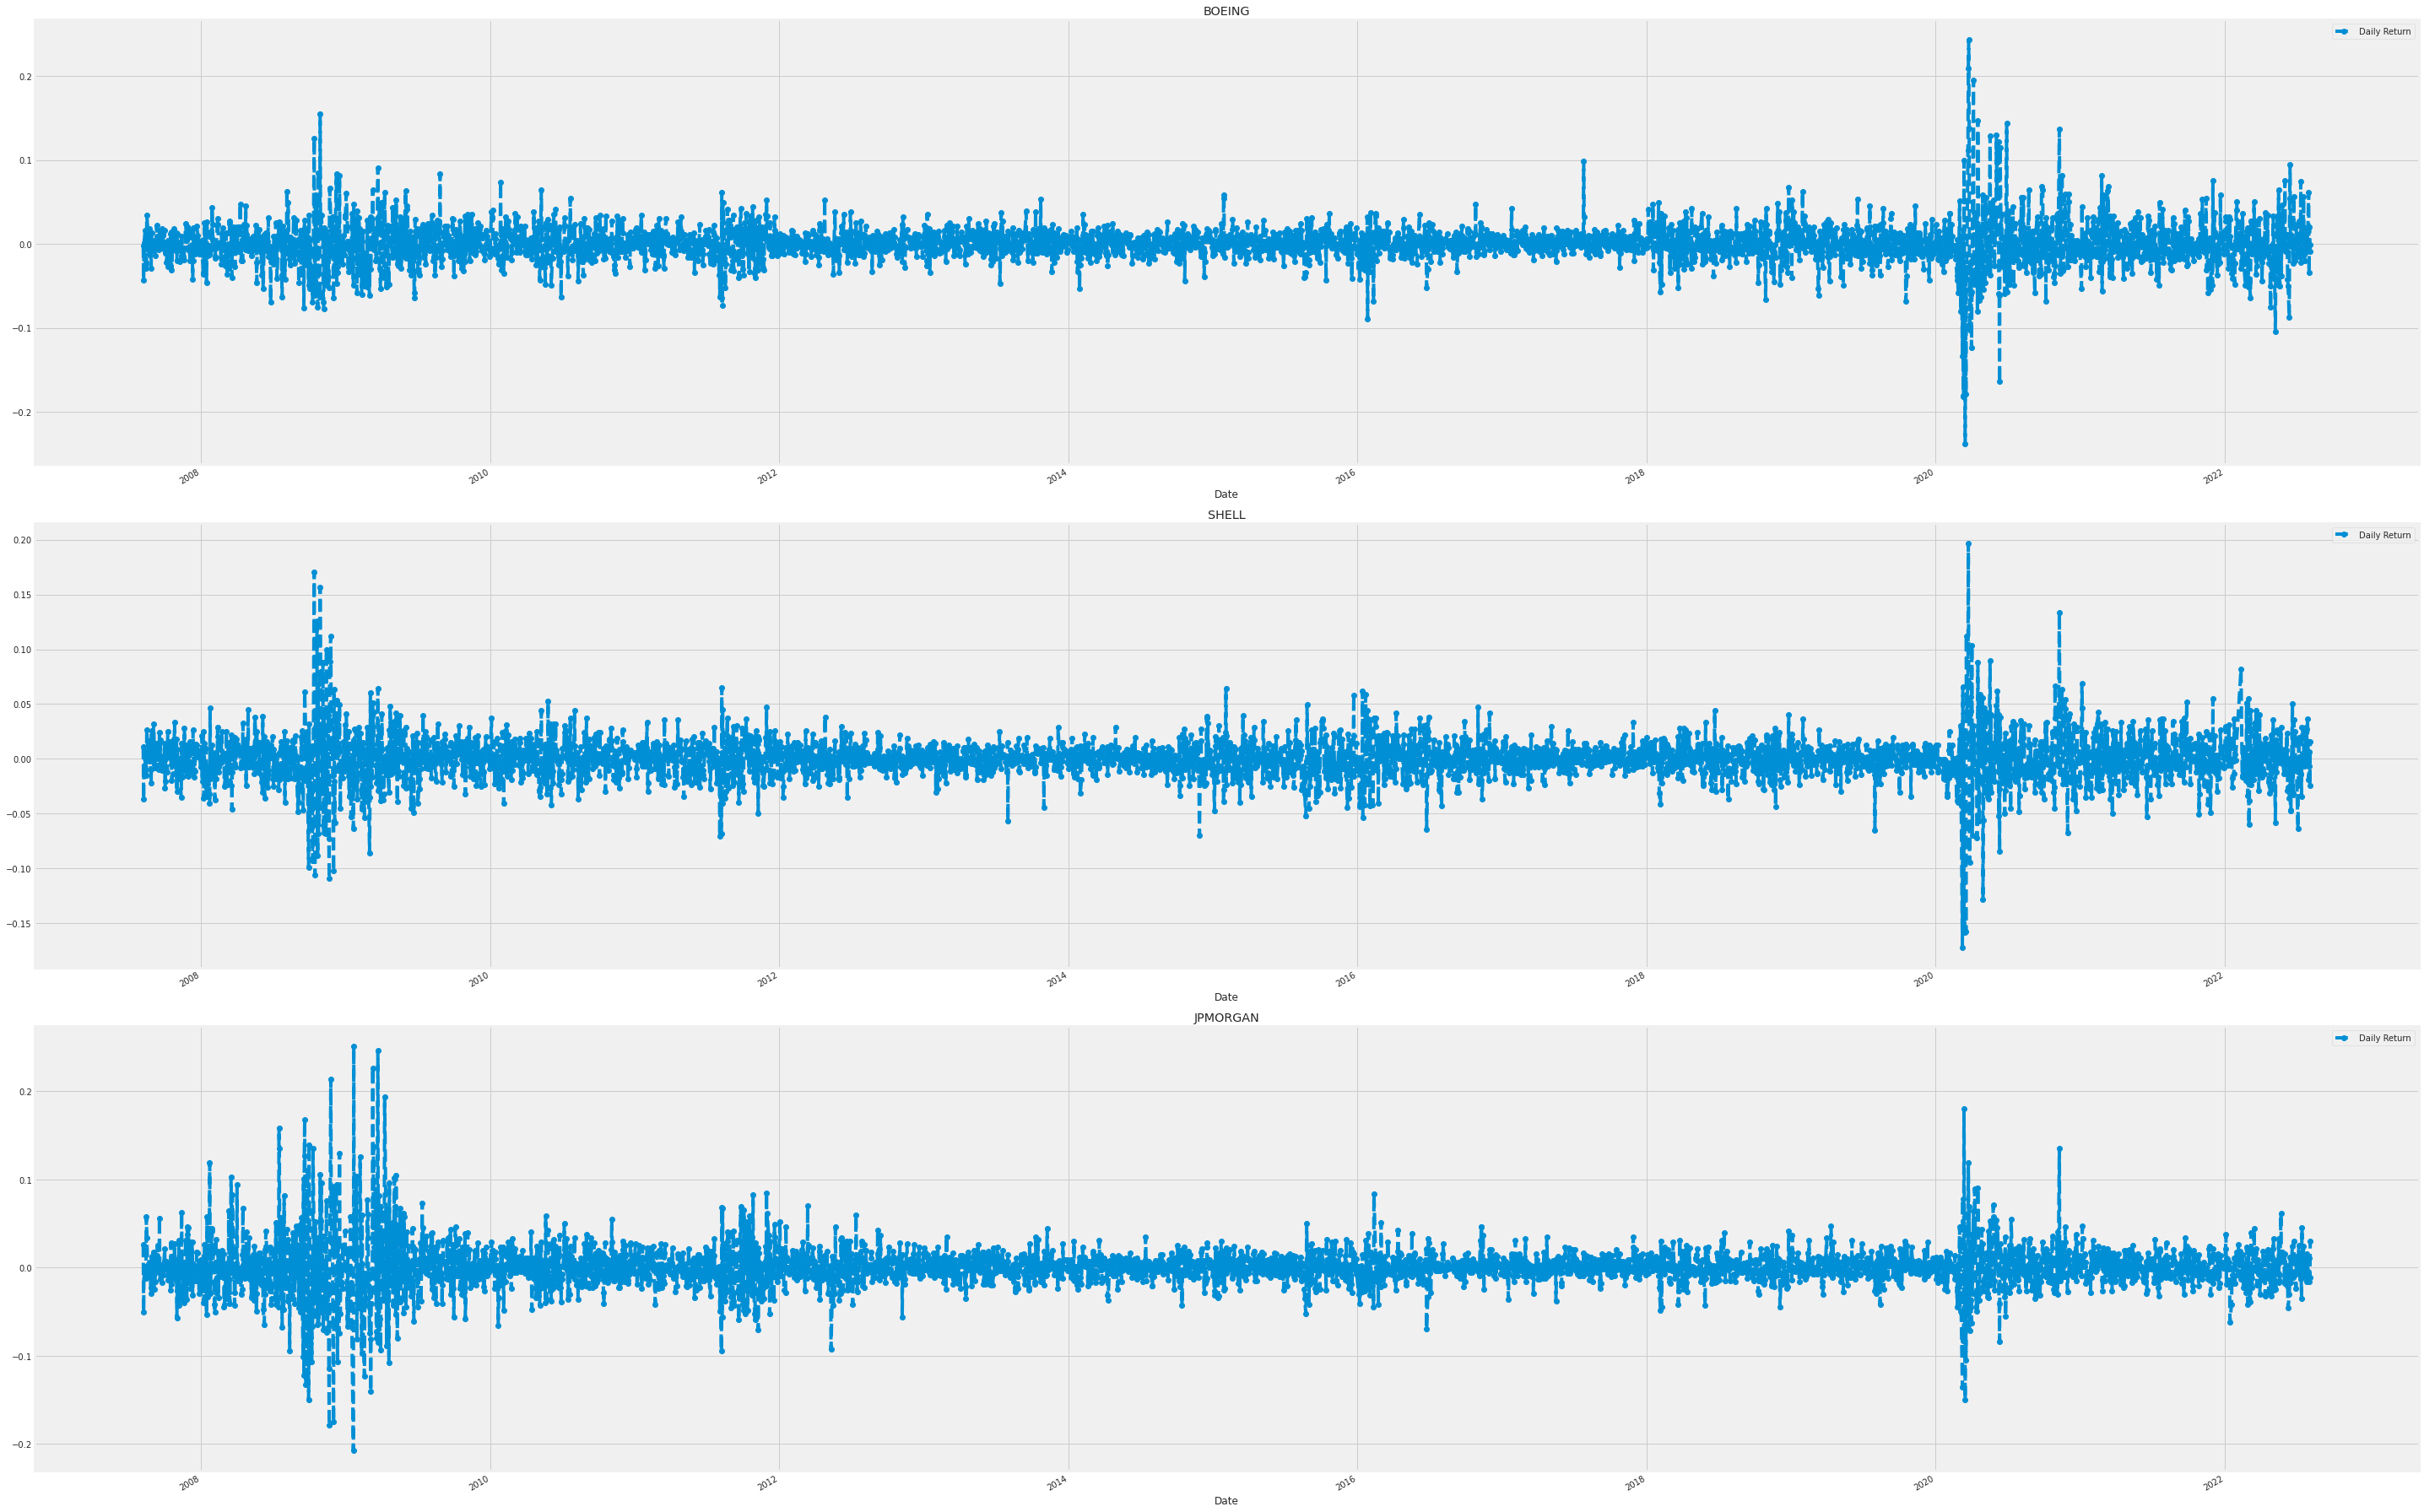

In [12]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_figheight(25)
fig.set_figwidth(40)

BA['Daily Return'].plot(ax=axes[0], legend=True, linestyle='--', marker='o')
axes[0].set_title('BOEING')

SHEL['Daily Return'].plot(ax=axes[1], legend=True, linestyle='--', marker='o')
axes[1].set_title('SHELL')

JPM['Daily Return'].plot(ax=axes[2], legend=True, linestyle='--', marker='o')
axes[2].set_title('JPMORGAN')

fig.tight_layout()

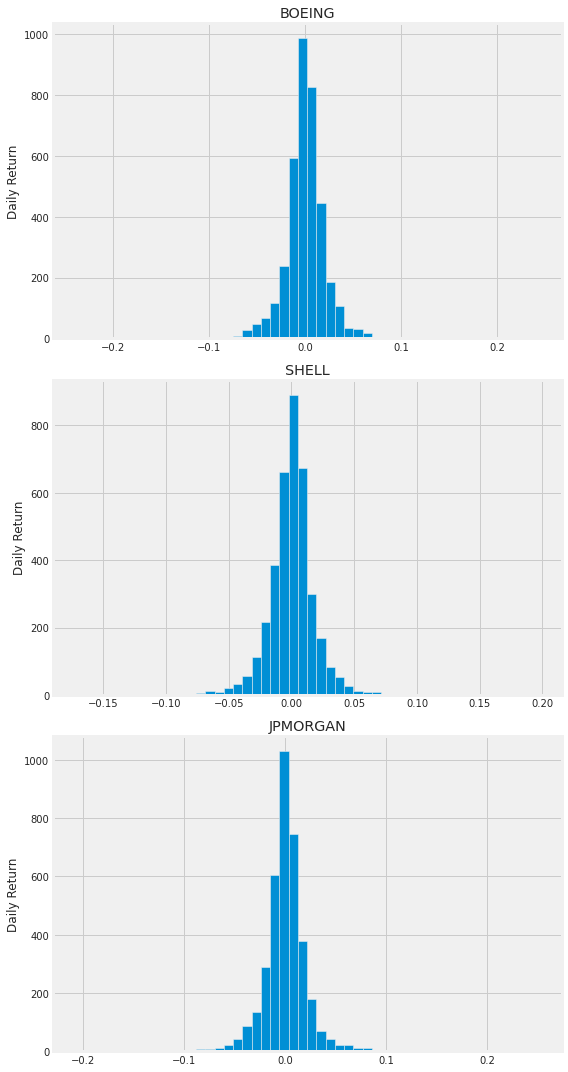

In [13]:
plt.figure(figsize=(8, 15))

for i, company in enumerate(company_list, 1):
    plt.subplot(3, 1, i)
    company['Daily Return'].hist(bins=50)
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()

In [14]:
# Grab all the closing prices for the tech stock list into one DataFrame
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']

# Let's take a quick look
closing_df.head() 

Symbols,BA,SHEL,JPM
Date,,,
2007-08-07,75.120720,34.554352,30.860800
2007-08-08,75.011208,34.933445,31.657164
2007-08-09,71.783531,33.660816,30.064425
2007-08-10,71.885757,33.453236,30.118885
2007-08-13,73.061462,33.480320,29.833006


In [15]:
# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head(10)

Symbols,BA,SHEL,JPM
Date,,,
2007-08-07,NaN,NaN,NaN
2007-08-08,-0.001458,0.010971,0.025805
2007-08-09,-0.043029,-0.036430,-0.050312
2007-08-10,0.001424,-0.006167,0.001811
2007-08-13,0.016355,0.000810,-0.009492
2007-08-14,-0.024188,-0.009301,-0.012092
2007-08-15,-0.021714,-0.014966,-0.006928
2007-08-16,-0.029002,-0.015193,0.057442
2007-08-17,0.034397,0.026648,0.033869


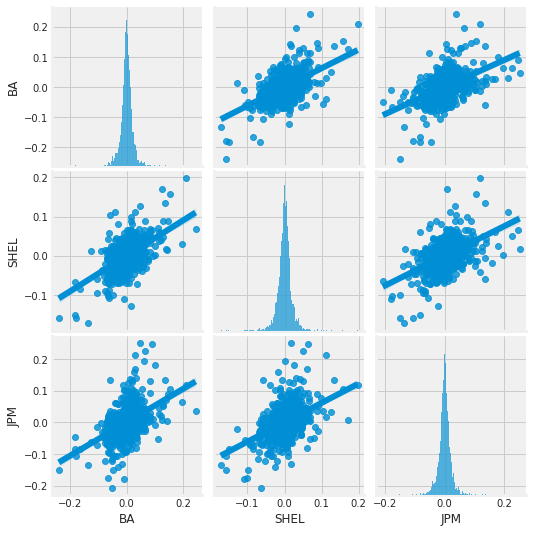

In [16]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

<AxesSubplot:xlabel='Symbols', ylabel='Symbols'>

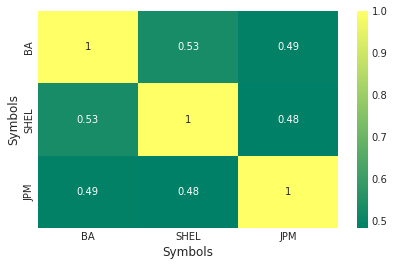

In [17]:
# Let's go ahead and use sebron for a quick correlation plot for the daily returns
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')

Contrary to what I expected, there is little correlation between the daily return of the Boeing and the shares of JPMORGAN or SHELL.

## 2.4 Volume

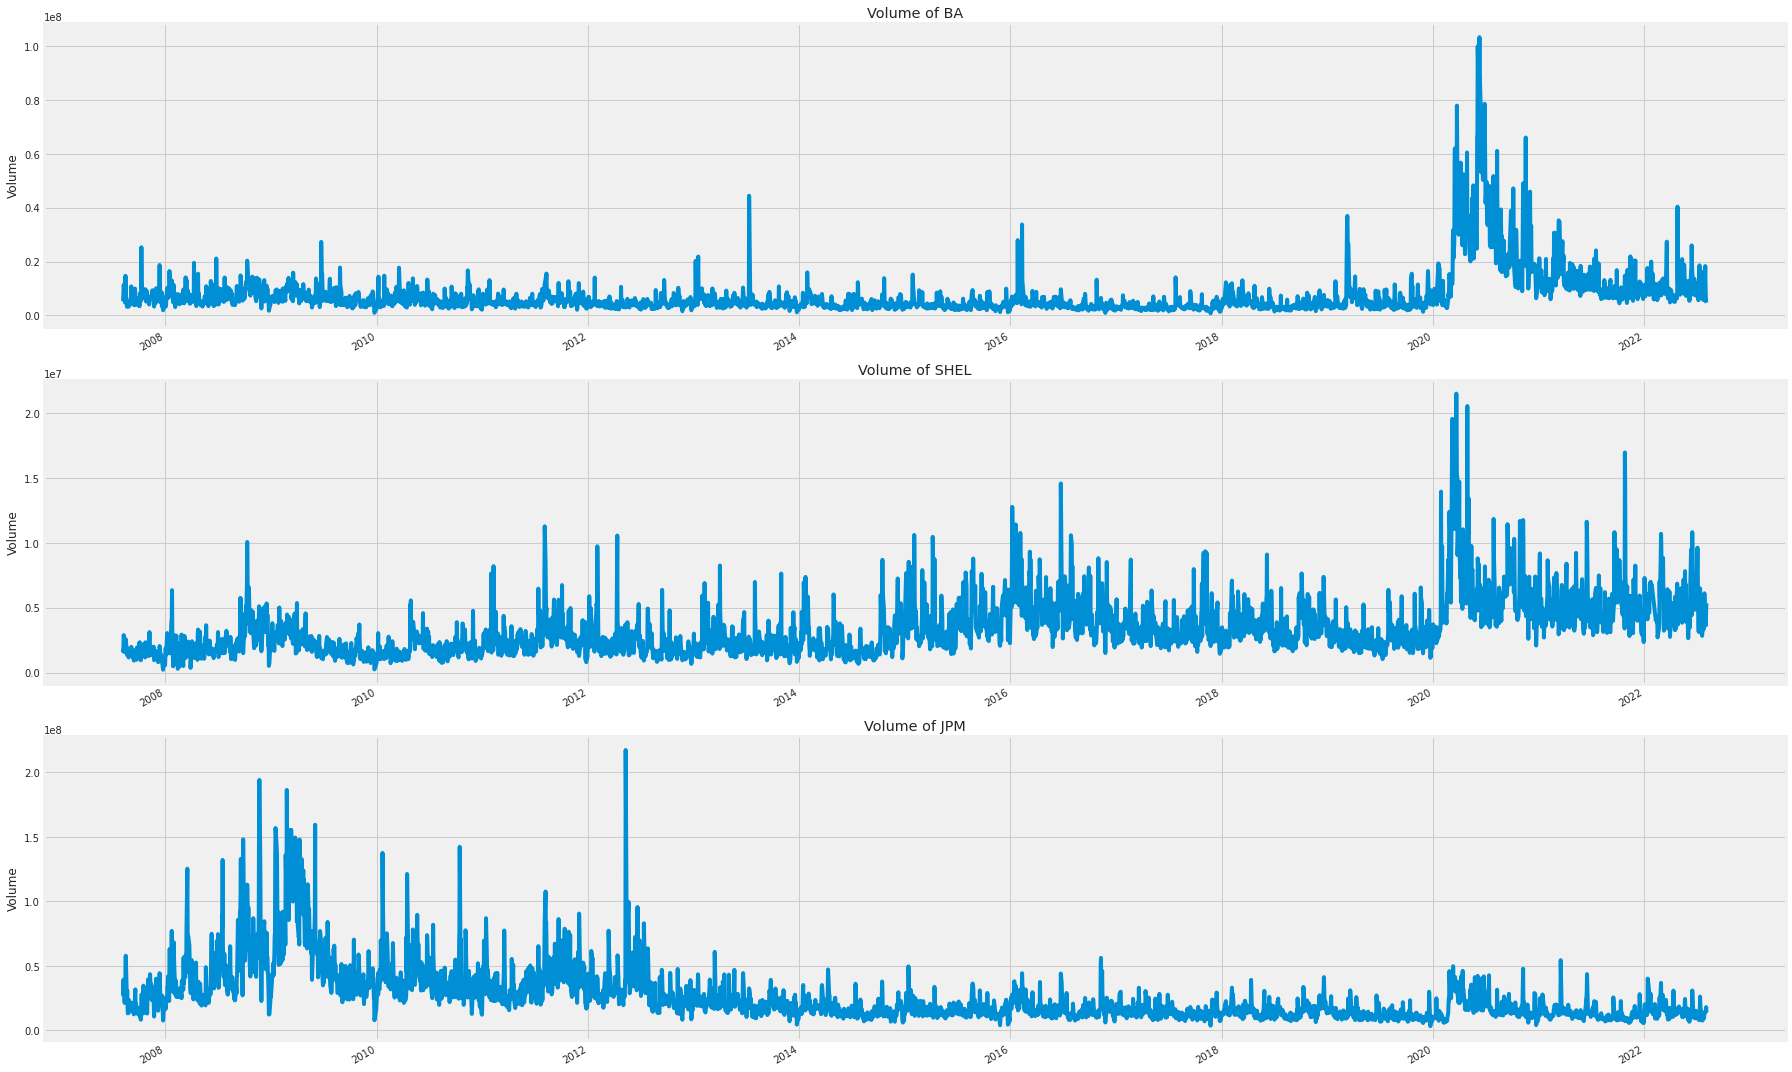

In [18]:
# Let's see a historical view of the sales volume

plt.figure(figsize=(25, 15))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(3, 1, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Volume of {tech_list[i - 1]}")
    
plt.tight_layout()

In [19]:
# Grab all the closing prices for the tech stock list into one DataFrame
close_volume_df = DataReader('BA', 'yahoo', start, end)[['Adj Close', 'Volume']]
# Let's take a quick look
close_volume_df.head() 

,Adj Close,Volume
Date,,
2007-08-07,75.120758,5250000.0
2007-08-08,75.011230,5820700.0
2007-08-09,71.783531,8723900.0
2007-08-10,71.885757,11406200.0
2007-08-13,73.061447,6144600.0


In [20]:
close_volume_change = close_volume_df.pct_change()
close_volume_change.head(10)

,Adj Close,Volume
Date,,
2007-08-07,NaN,NaN
2007-08-08,-0.001458,0.108705
2007-08-09,-0.043030,0.498772
2007-08-10,0.001424,0.307466
2007-08-13,0.016355,-0.461293
2007-08-14,-0.024188,-0.209973
2007-08-15,-0.021714,0.097396
2007-08-16,-0.029003,1.761807
2007-08-17,0.034397,-0.427800


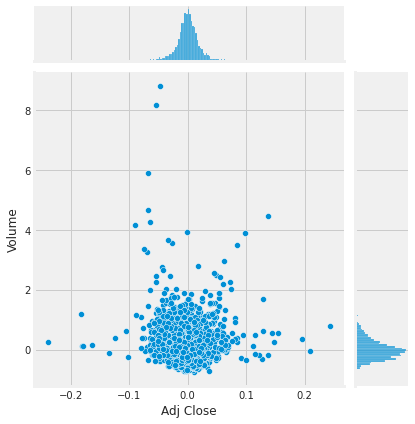

In [21]:
sns.jointplot(x='Adj Close', y='Volume', data=close_volume_change, kind='scatter')

<AxesSubplot:>

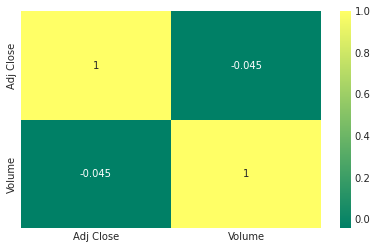

In [22]:
# Let's go ahead and use sebron for a quick correlation plot for the daily returns
sns.heatmap(close_volume_change.corr(), annot=True, cmap='summer')

# 3 BOEING PRICE PREDICTION

Here I want to create a dataset with **Open, High, Low, Adj Close, Volume, Time, MA** of the three stock in 15 days to predict the price for the next 10 days

You can use this [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series#split_the_data) to understand how to process time series data with tensorflow

# 3.1 Inspect and Cleanup

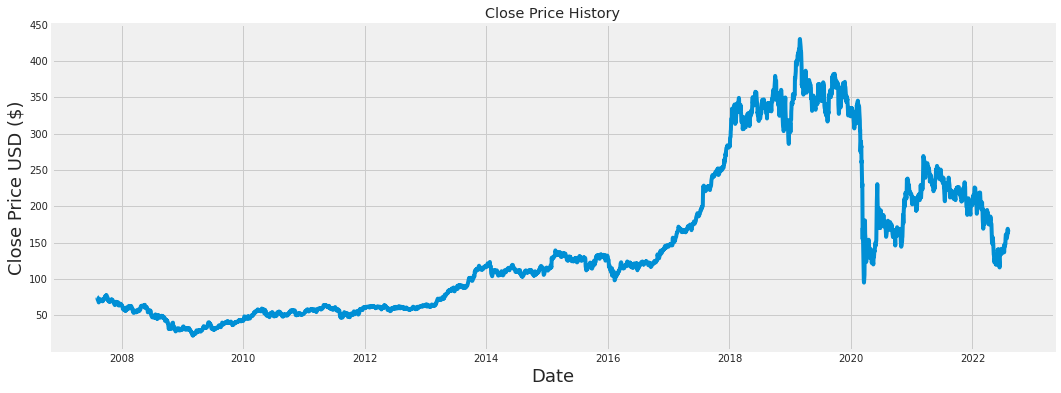

In [23]:
# Let's see a historical view of the closing price
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(BA['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [24]:
company_list = [BA ,SHEL, JPM]
df = pd.DataFrame()

for company, stock  in zip(company_list,tech_list):
    
    company = company.drop(labels =['company_name', 'Close'], axis =1) #remove unnecessary columns
    rename_dict = {name: str(name + '_' + stock) for name in company.columns}
    company = company.rename(columns=rename_dict)
    for col in company.columns:
        df[col] = pd.DataFrame(company[col])
    
df = df.dropna()
df.head(10)

,Open_BA,High_BA,Low_BA,Adj Close_BA,Volume_BA,MA12_BA,MA26_BA,MA50_BA,Daily Return_BA,Open_SHEL,...,Daily Return_SHEL,Open_JPM,High_JPM,Low_JPM,Adj Close_JPM,Volume_JPM,MA12_JPM,MA26_JPM,MA50_JPM,Daily Return_JPM
Date,,,,,,,,,,,,,,,,,,,,,
2007-10-16,94.500000,96.339996,93.029999,70.060158,9845700,73.570802,73.779901,72.458261,0.011706,84.459999,...,0.009166,46.000000,46.400002,44.599998,30.953661,22510200,32.126051,31.726446,31.137914,-0.025071
2007-10-17,96.519997,97.050003,94.629997,69.804535,8097500,72.897756,73.727941,72.351937,-0.003649,84.779999,...,-0.004955,47.040001,47.119999,45.750000,31.818245,34659600,32.122459,31.784214,31.157063,0.027932
2007-10-18,95.360001,97.150002,94.800003,70.790375,6762300,72.350677,73.689181,72.267520,0.014123,84.879997,...,0.015412,46.099998,46.130001,45.450001,31.495752,19397900,32.072139,31.831411,31.153835,-0.010135
2007-10-19,96.540001,97.000000,93.790001,68.570404,9205200,71.692235,73.547344,72.203258,-0.031360,85.459999,...,-0.019965,45.790001,46.599998,44.959999,30.891912,29500400,31.958921,31.825801,31.170384,-0.019172
2007-10-22,93.160004,95.040001,92.599998,69.322571,7938900,71.109859,73.423201,72.151994,0.010969,82.309998,...,-0.013462,44.900002,45.930000,44.660000,31.132072,18094100,31.851419,31.830999,31.190648,0.007774
2007-10-23,95.760002,95.959999,94.160004,69.337189,6109100,70.665627,73.319563,72.077509,0.000211,83.820000,...,0.010989,45.919998,45.990002,45.130001,31.523195,13519100,31.757641,31.857785,31.224451,0.012563
2007-10-24,95.690002,96.080002,93.019997,68.833321,9715600,70.251211,73.201320,72.028291,-0.007267,83.930000,...,0.017917,45.730000,46.439999,44.740002,31.749641,27352800,31.690739,31.827048,31.269999,0.007183
2007-10-25,94.879997,98.970001,92.000000,70.103943,8169100,69.919556,73.088413,72.035447,0.018459,85.110001,...,-0.002582,46.099998,46.549999,45.150002,31.598654,20076400,31.603822,31.797048,31.316610,-0.004756
2007-10-26,96.250000,96.550003,95.050003,70.118553,5185400,69.757686,72.941521,72.083352,0.000208,87.089996,...,0.033294,46.959999,47.450001,45.930000,32.470112,18851700,31.627265,31.816535,31.347027,0.027579


# 3.2 Feature engineering
The Date Time column is very useful, but not in this string form, so we need to turn them into sin cos value

In [25]:
#Enable the Date index of yfinance data
df.reset_index(inplace=True)
#Extract date
date_time = pd.to_datetime(df.pop('Date'))

In [26]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

week = 7*24*60*60
month = 30*24*60*60
year = (12)*month

df['week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

The stock trading market operates 5 days a week (Mon-Friday). We see a week has 5 days, and a month has about 20 days 

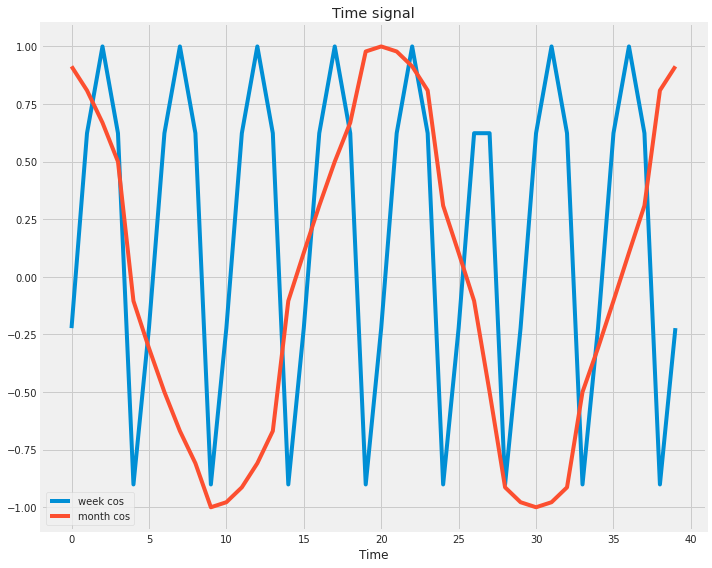

In [27]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(df['week cos'][:40]), label ='week cos')
plt.plot(np.array(df['month cos'][:40]), label = 'month cos')
plt.legend()
plt.xlabel('Time')
plt.title('Time signal')

plt.tight_layout()

In [28]:
df.head()

,Open_BA,High_BA,Low_BA,Adj Close_BA,Volume_BA,MA12_BA,MA26_BA,MA50_BA,Daily Return_BA,Open_SHEL,...,MA12_JPM,MA26_JPM,MA50_JPM,Daily Return_JPM,week sin,week cos,month sin,month cos,Year sin,Year cos
0,94.500000,96.339996,93.029999,70.060158,9845700,73.570802,73.779901,72.458261,0.011706,84.459999,...,32.126051,31.726446,31.137914,-0.025071,-9.749279e-01,-0.222521,0.406737,0.913545,0.848048,-0.529919
1,96.519997,97.050003,94.629997,69.804535,8097500,72.897756,73.727941,72.351937,-0.003649,84.779999,...,32.122459,31.784214,31.157063,0.027932,-7.818315e-01,0.623490,0.587785,0.809017,0.838671,-0.544639
2,95.360001,97.150002,94.800003,70.790375,6762300,72.350677,73.689181,72.267520,0.014123,84.879997,...,32.072139,31.831411,31.153835,-0.010135,2.275420e-13,1.000000,0.743145,0.669131,0.829038,-0.559193
3,96.540001,97.000000,93.790001,68.570404,9205200,71.692235,73.547344,72.203258,-0.031360,85.459999,...,31.958921,31.825801,31.170384,-0.019172,7.818315e-01,0.623490,0.866025,0.500000,0.819152,-0.573576
4,93.160004,95.040001,92.599998,69.322571,7938900,71.109859,73.423201,72.151994,0.010969,82.309998,...,31.851419,31.830999,31.190648,0.007774,-4.338837e-01,-0.900969,0.994522,-0.104528,0.788011,-0.615661


In [29]:
df.describe()

,Open_BA,High_BA,Low_BA,Adj Close_BA,Volume_BA,MA12_BA,MA26_BA,MA50_BA,Daily Return_BA,Open_SHEL,...,MA12_JPM,MA26_JPM,MA50_JPM,Daily Return_JPM,week sin,week cos,month sin,month cos,Year sin,Year cos
count,3719.000000,3719.000000,3719.000000,3719.000000,3.719000e+03,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,...,3719.000000,3719.000000,3719.000000,3719.000000,3.719000e+03,3719.000000,3.719000e+03,3719.000000,3719.000000,3.719000e+03
mean,154.985289,156.788922,153.068163,143.742512,7.392519e+06,143.620901,143.461628,143.248474,0.000473,59.116600,...,63.992944,63.823015,63.548752,0.000654,-2.856568e-01,0.239732,-7.616693e-04,0.002612,0.011025,-6.359232e-04
std,99.263359,100.376466,98.092624,101.710701,8.434122e+06,101.575650,101.379694,101.081001,0.023505,12.268134,...,39.110942,38.992374,38.844506,0.025538,6.298417e-01,0.681513,7.067907e-01,0.707608,0.705928,7.083870e-01
min,29.219999,30.020000,29.049999,22.244295,7.889000e+05,23.810719,25.324688,26.819837,-0.238484,23.170000,...,14.249348,15.583074,16.700745,-0.207274,-9.749279e-01,-0.900969,-9.945219e-01,-1.000000,-1.000000,-1.000000e+00
25%,73.289997,73.930000,72.674999,59.033821,3.532700e+06,59.137660,59.303809,59.429600,-0.009607,51.529999,...,30.916415,30.622554,30.627841,-0.008963,-7.818315e-01,-0.222521,-7.431448e-01,-0.669131,-0.694658,-7.071068e-01
50%,130.899994,132.000000,129.330002,116.044594,4.942700e+06,116.576817,115.800572,115.129274,0.000396,60.639999,...,49.036892,48.715220,48.395350,0.000146,-4.338837e-01,0.623490,-6.911254e-15,0.104528,0.017452,7.354690e-15
75%,207.334999,211.064995,204.830002,206.005005,7.763850e+06,206.595416,206.660162,207.408801,0.010652,68.199997,...,94.535550,94.120809,94.188600,0.010026,3.912279e-13,0.623490,7.431448e-01,0.669131,0.719340,7.071068e-01
max,446.010010,446.010010,440.190002,430.299957,1.032128e+08,418.598946,407.244227,388.826219,0.243186,88.089996,...,166.428574,164.870109,162.730843,0.250967,7.818315e-01,1.000000,9.945219e-01,1.000000,1.000000,1.000000e+00


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3719 entries, 0 to 3718
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open_BA            3719 non-null   float64
 1   High_BA            3719 non-null   float64
 2   Low_BA             3719 non-null   float64
 3   Adj Close_BA       3719 non-null   float64
 4   Volume_BA          3719 non-null   int64  
 5   MA12_BA            3719 non-null   float64
 6   MA26_BA            3719 non-null   float64
 7   MA50_BA            3719 non-null   float64
 8   Daily Return_BA    3719 non-null   float64
 9   Open_SHEL          3719 non-null   float64
 10  High_SHEL          3719 non-null   float64
 11  Low_SHEL           3719 non-null   float64
 12  Adj Close_SHEL     3719 non-null   float64
 13  Volume_SHEL        3719 non-null   float64
 14  MA12_SHEL          3719 non-null   float64
 15  MA26_SHEL          3719 non-null   float64
 16  MA50_SHEL          3719 

In [31]:
# Get the number of rows to train the model on
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print ('len(train_df)',len(train_df))

len(train_df) 2603


In [32]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

print ('train_df\n',train_df.head())

train_df
     Open_BA   High_BA    Low_BA  Adj Close_BA  Volume_BA   MA12_BA   MA26_BA  \
0 -0.219323 -0.202932 -0.229024     -0.401387   1.628939 -0.335917 -0.328312   
1 -0.183547 -0.190458 -0.200514     -0.405932   1.015286 -0.348120 -0.329279   
2 -0.204091 -0.188701 -0.197485     -0.388407   0.546604 -0.358039 -0.330000   
3 -0.183193 -0.191336 -0.215482     -0.427870   1.404110 -0.369977 -0.332640   
4 -0.243055 -0.225771 -0.236686     -0.414499   0.959614 -0.380535 -0.334950   

    MA50_BA  Daily Return_BA  Open_SHEL  ...  MA12_JPM  MA26_JPM  MA50_JPM  \
0 -0.346718         0.601882   2.168105  ... -0.553564 -0.575050 -0.607181   
1 -0.348779        -0.243773   2.199978  ... -0.553768 -0.571720 -0.606048   
2 -0.350415         0.735016   2.209938  ... -0.556622 -0.569000 -0.606239   
3 -0.351660        -1.770002   2.267709  ... -0.563043 -0.569323 -0.605260   
4 -0.352654         0.561327   1.953955  ... -0.569140 -0.569024 -0.604061   

   Daily Return_JPM  week sin  week cos 

# 3.3 Data Windowing
The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

* The width (number of time steps) of the input and label windows.
* The time offset between them.
* Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for: **Single-output and multi-time-step predictions.**
Which means the model will predict Adj Close price for the next 20 days

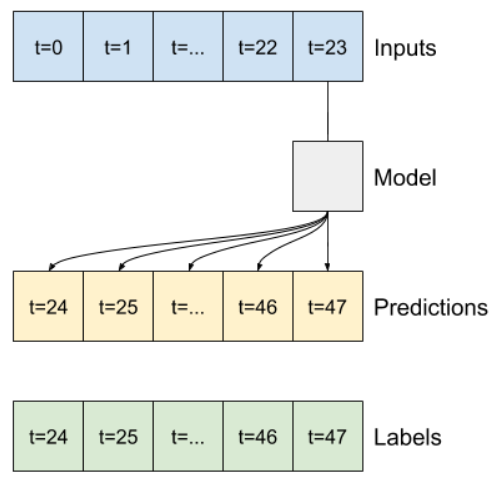

This section defines a ```WindowGenerator class```. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
2. Split windows of features into (features, labels) pairs.
3. Plot the content of the resulting windows.
4. Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.

In [33]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

I have run this notebook several time with input_width = 20,  OUT_STEPS = 10 and the result turned out not good with complex model like (CNN-LSTM, complex-CNN). While simple CNN (just take the last 3 time step, 1 conv layer) achieve the best result. So the window size may have big effect on the result (recent time steps have greater influence on the result in short time). Because of it, I'll change the parameters a little bit (input_width = 10,  OUT_STEPS = 5)

The effect of window size can be seen in [5 CONCLUSION](#5-CONCLUSION)

In [34]:
OUT_STEPS = 10
input_width =20 
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns = ['Adj Close_BA'])
multi_window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20 21 22 23 24 25 26 27 28 29]
Label column name(s): ['Adj Close_BA']

# 3.4 Split Window
The window above return just indices of inputs and labels. This split window actually help us seperate the inputs and labels features

In [35]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [36]:
# Example for split window
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[100:100+multi_window.total_window_size]),
                           np.array(train_df[200:200+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

2022-08-07 08:54:04.905937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 08:54:05.071013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 08:54:05.075289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 08:54:05.082375: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

All shapes are: (batch, time, features)
Window shape: (3, 30, 33)
Inputs shape: (3, 20, 33)
Labels shape: (3, 10, 1)


# 3.5 Plot

In [37]:
def plot(self, model=None, plot_col='Adj Close_BA', max_subplots=3):
    
    inputs, labels = self.split_window(example_window)
    plt.figure(figsize=(20, 10))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [day]')

WindowGenerator.plot = plot

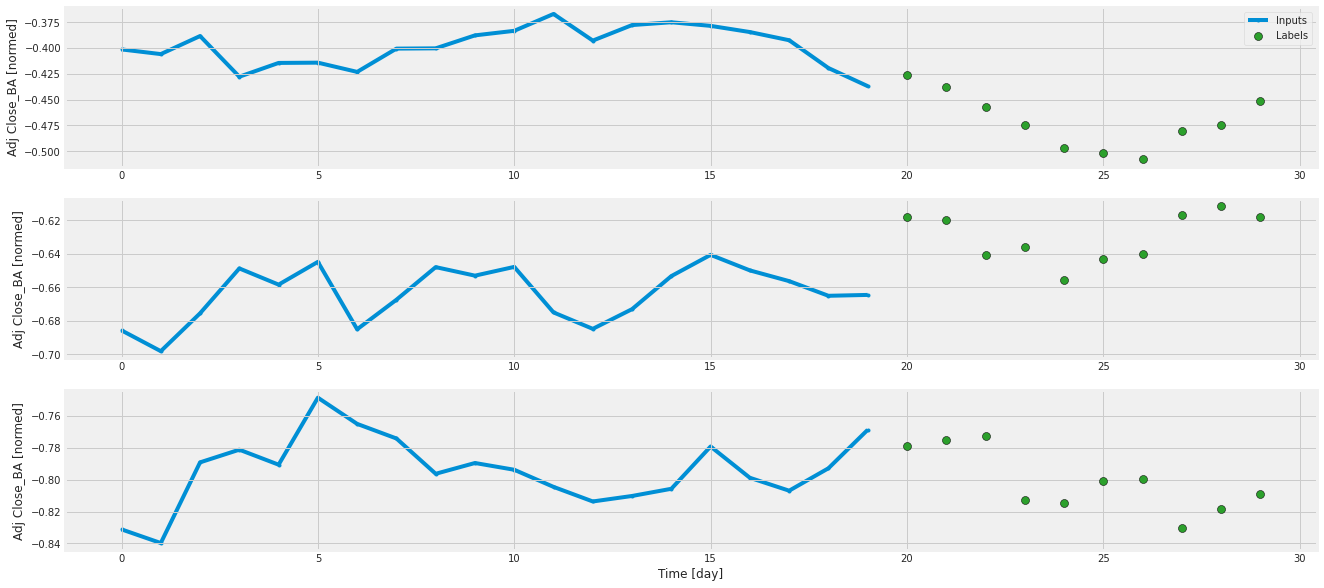

In [38]:
multi_window.plot()

# 3.6 Create Dataset

Finally, this make_dataset method will take a time series DataFrame and convert it to a ```tf.data.Dataset``` of ***(input_window, label_window)*** pairs using the``` tf.keras.utils.timeseries_dataset_from_array``` function:

In [39]:
def make_dataset(self, data): #data lấy liên tục 
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,#to avoid sequence bias
      batch_size=64,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

The WindowGenerator object holds training, validation, and test data.

Add properties for accessing them as ```tf.data.Datasets``` using the make_dataset method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [40]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [41]:
for inputs, labels in multi_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (64, 20, 33)
Labels shape (batch, time, features): (64, 10, 1)


2022-08-07 08:54:10.738293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [42]:
multi_window.train

<MapDataset shapes: ((None, 20, 33), (None, 10, 1)), types: (tf.float32, tf.float32)>

# 3.7 Build & Train model

In [43]:
tf.keras.backend.clear_session()
MAX_EPOCHS = 100

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def compile_and_fit(model, window, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

        
    model.compile(#loss=tf.keras.losses.MeanSquaredError()
                  loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,lr_schedule],verbose=1)
    return history

Ploting 
* Train loss - validation loss
* Loss - Learning rate

In [44]:
def plot_train (history):
    # list all data in history
    print(history.history.keys())

    # summarize history for loss

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

## 3.7.1 Simple CNN
This model is from tensorflow, let's see it as base line model

In [45]:
CONV_WIDTH =3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

12/12 [==============================] - 0s 6ms/step - loss: 0.0838 - mean_absolute_error: 0.2915 - root_mean_squared_error: 0.4369
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


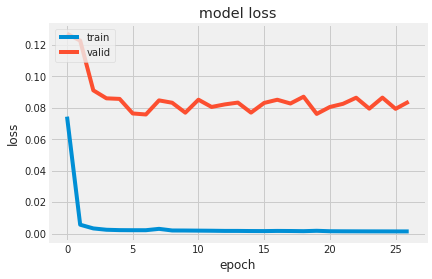

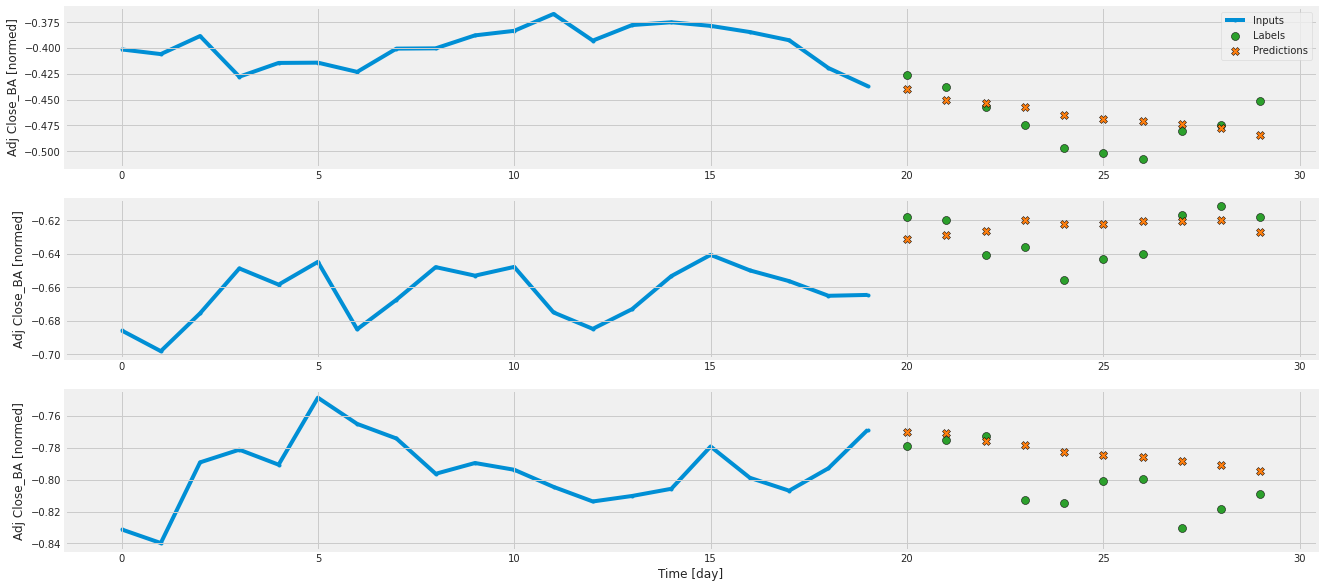

In [46]:
multi_conv_history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance = {}
multi_performance = {}

IPython.display.clear_output()

multi_val_performance['Simple Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Simple Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
plot_train(multi_conv_history)
multi_window.plot(multi_conv_model)

In [47]:
multi_conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 3, 33)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 256)            25600     
_________________________________________________________________
dense (Dense)                (None, 1, 330)            84810     
_________________________________________________________________
reshape (Reshape)            (None, 10, 33)            0         
Total params: 110,410
Trainable params: 110,410
Non-trainable params: 0
_________________________________________________________________


## 3.7.2 Multi LSTM

12/12 [==============================] - 0s 13ms/step - loss: 0.1449 - mean_absolute_error: 0.4033 - root_mean_squared_error: 0.5596
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


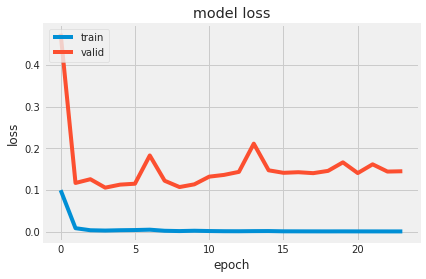

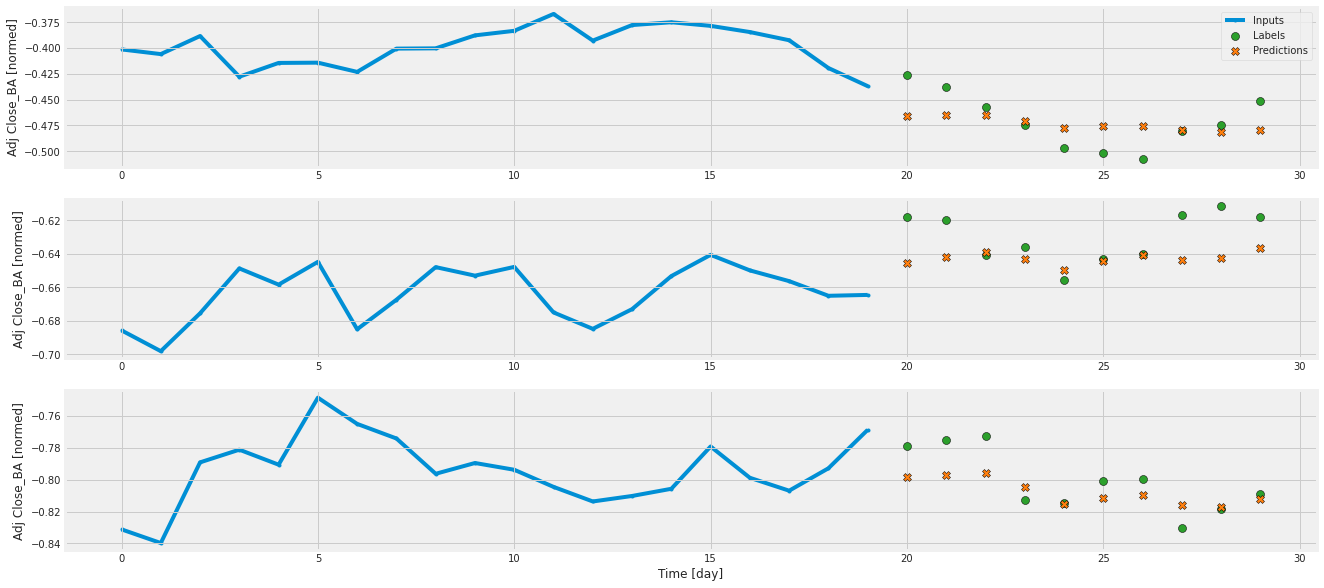

In [48]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(1024, return_sequences=True),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.LSTM(1024, return_sequences=False),
    
    tf.keras.layers.Dense(512, activation = 'relu'), 
    
    tf.keras.layers.Dense(256),
    
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_multi_lstm = compile_and_fit(multi_lstm_model, multi_window)
IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
plot_train(history_multi_lstm)
multi_window.plot(multi_lstm_model)

In [49]:
multi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 1024)          4333568   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 330)               84810     
_________________________________________________________________
reshape_1 (Reshape)          (None, 10, 33)            0         
Total params: 13,467,210
Trainable params: 13,467,210
Non-trainable params: 0
__________________________________________

## 3.7.3 Complex CNN

In [50]:
CONV_WIDTH = 3

def build_CNN_model(input_shape = (input_width,num_features)): #input_shape (time steps,features)
    
    input = tf.keras.Input(shape=(input_shape[0],input_shape[1],1))
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)))(input)

    #x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    
    #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.5)(x) 
    
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(512)(x)
                              
    x = tf.keras.layers.Dense(OUT_STEPS*num_features) (x)
    # Shape => [batch, out_steps, features]
    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

CNN_model = build_CNN_model()
CNN_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 33, 1)]       0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 31, 64)        256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 29, 128)       24704     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 27, 256)       98560     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 25, 128)       98432     
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              131074

12/12 [==============================] - 0s 10ms/step - loss: 0.1605 - mean_absolute_error: 0.4477 - root_mean_squared_error: 0.5859
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


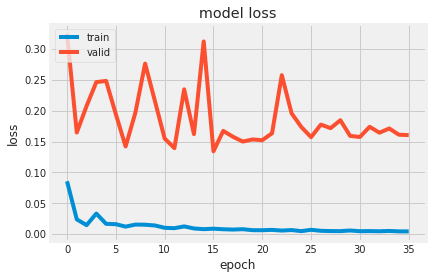

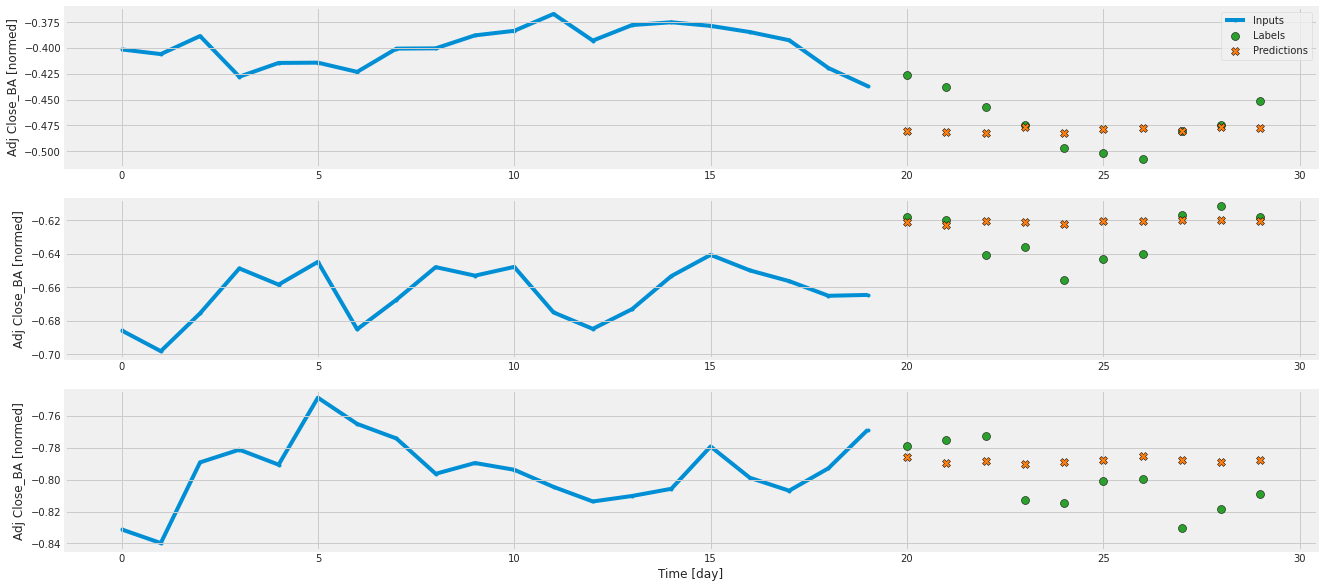

In [51]:
tf.keras.backend.clear_session()
history_CNN = compile_and_fit(CNN_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['CNN'] = CNN_model.evaluate(multi_window.val)
multi_performance['CNN'] = CNN_model.evaluate(multi_window.test, verbose=0)
plot_train(history_CNN)
multi_window.plot(CNN_model)

Wow can't believe that TimeDistributed layer works!!!

## 3.7.4 CNN + LSTM

In [52]:
CONV_WIDTH = 3

def build_CNN_LSTM_model(input_shape = (input_width,num_features)):
    
    input = tf.keras.Input(shape=(input_shape[0],input_shape[1],1))
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)))(input)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
    
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(x)
    
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=False, dropout=0.5))(x)
    
    x = tf.keras.layers.Dense(OUT_STEPS*num_features)(x)

    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

CNN_LSTM_model = build_CNN_LSTM_model()
CNN_LSTM_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 33, 1)]       0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 31, 64)        256       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 15, 64)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 13, 128)       24704     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 6, 128)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 6, 128)        512       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 4, 256)        98560 

12/12 [==============================] - 0s 10ms/step - loss: 0.4623 - mean_absolute_error: 0.8415 - root_mean_squared_error: 1.0396
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


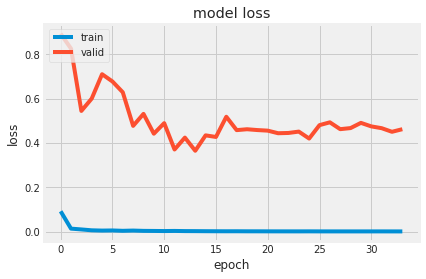

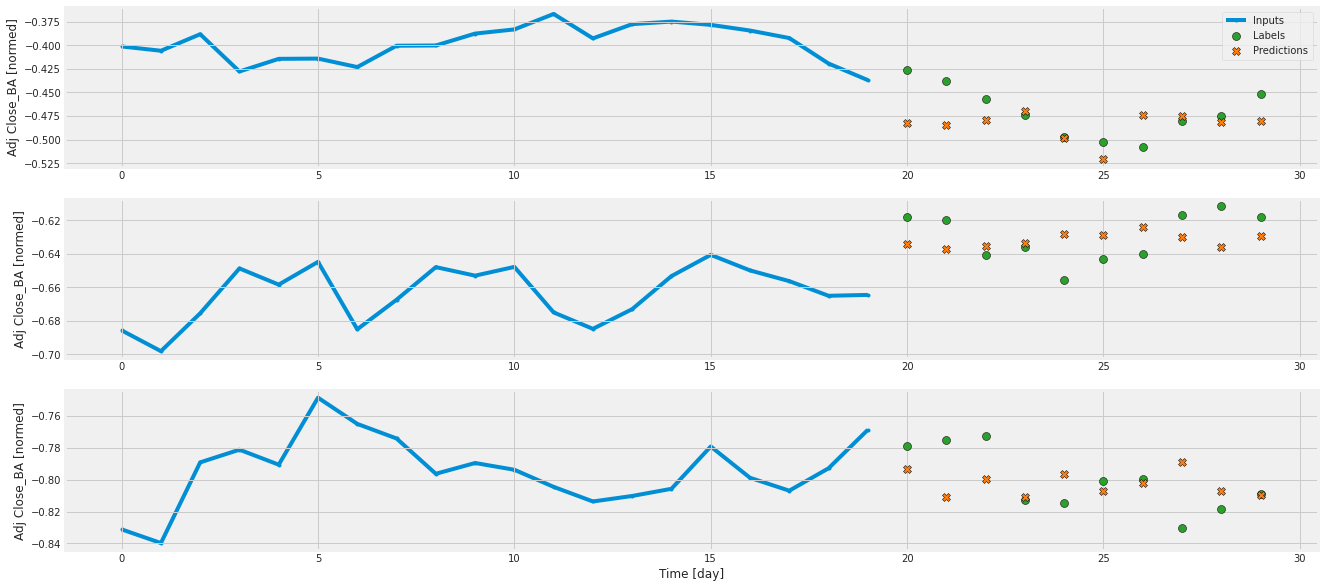

In [53]:
history_CNN_LSTM = compile_and_fit(CNN_LSTM_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['CNN_LSTM'] = CNN_LSTM_model.evaluate(multi_window.val)
multi_performance['CNN_LSTM'] = CNN_LSTM_model.evaluate(multi_window.test, verbose=0)
plot_train(history_CNN_LSTM)
multi_window.plot(CNN_LSTM_model)

## 3.7.5 LSTM + Dense

In [54]:
def build_LSTM_Dense_model():
    
    input = tf.keras.Input(shape= (input_width,num_features))
    
    x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True))(input)
    
    x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True, dropout=0.5))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='relu'))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu'))(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(OUT_STEPS*num_features)(x)

    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

LSTM_Dense_model = build_LSTM_Dense_model()
LSTM_Dense_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 33)]          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 512)           593920    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20, 512)           1574912   
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 256)           131328    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 20, 128)           32896     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 330)               8451

12/12 [==============================] - 0s 9ms/step - loss: 0.2964 - mean_absolute_error: 0.6653 - root_mean_squared_error: 0.7919
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


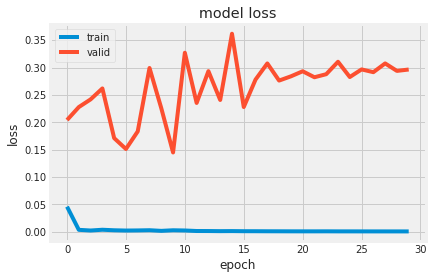

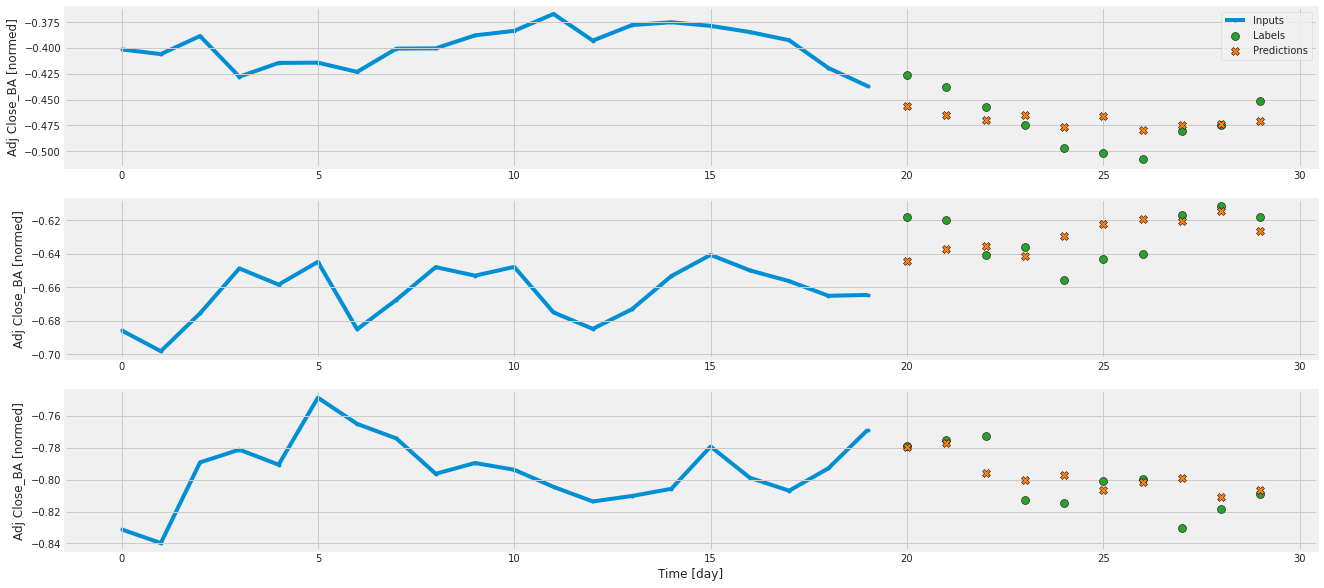

In [55]:
history_LSTM_Dense = compile_and_fit(LSTM_Dense_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['LSTM_Dense'] = LSTM_Dense_model.evaluate(multi_window.val)
multi_performance['LSTM_Dense'] = LSTM_Dense_model.evaluate(multi_window.test, verbose=0)
plot_train(history_LSTM_Dense)
multi_window.plot(LSTM_Dense_model)

# 4 RESULT 

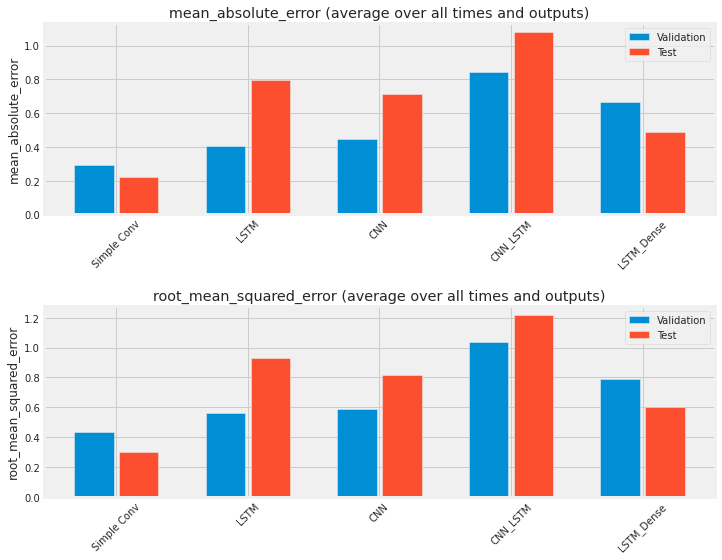

In [56]:
x = np.arange(len(multi_performance))
width = 0.3

plt.figure(figsize=(10, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)

metric_name = CNN_LSTM_model.metrics_names[1:] #we don't draw loss
for i, name in enumerate(metric_name,1):
    plt.subplot(2, 1, i)
    
    metric_index = CNN_LSTM_model.metrics_names.index(name)
    val_mae = [v[metric_index] for v in multi_val_performance.values()]
    test_mae = [v[metric_index] for v in multi_performance.values()]

    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.title (f'{name} (average over all times and outputs)')
    plt.xticks(ticks=x, labels=multi_performance.keys(),
               rotation=45)
    plt.ylabel(f'{name}') #(average over all times and outputs)
    _ = plt.legend()
    
plt.tight_layout()

# 5 CONCLUSION
## 5.1 Window size
Look at the pictures below, we can see that in general, when we increase the input_width and OUT_STEPS. 
* The MAE and RMSE increase. It shows that the predictions are more related to recent data. Furthermore,  
* Multi LSTM model errors in test data are higher than validation data (The window size can solve overfitting??)
* One exception is CNN+LSTM model. The errors increase. I still don't know why more complicated models achieve worse results than simple ones (the simple CNN which has just 1 Conv layer/use the last 3 time steps) gain outstanding performance

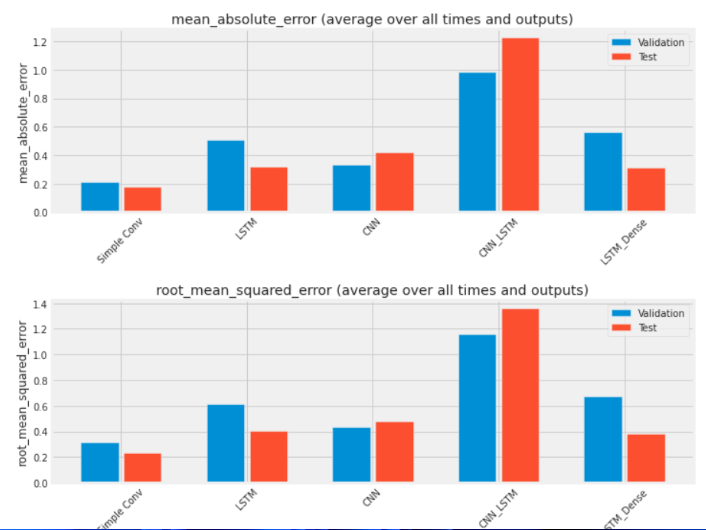

input_width = 10,  OUT_STEPS = 5

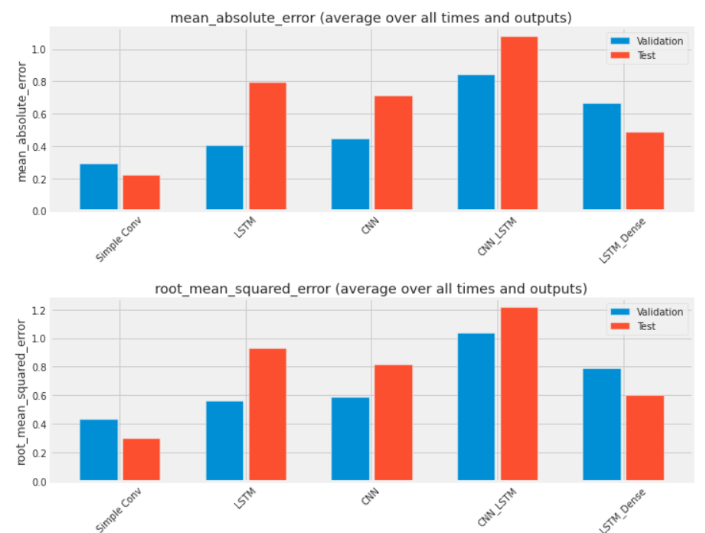

input_width = 20,  OUT_STEPS = 10